In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 2.8 MB/s 
     |████████████████████████████████| 3.5 MB 2.6 MB/s 


In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
import torch_geometric.utils as uts

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

import networkx as nx 
from networkx.algorithms.isomorphism import ISMAGS, GraphMatcher


Copy the simple encoder 

In [2]:
def Simple_Encoder(G, F_set ,symmetry = True, line = True, format = 'Torch'):
    '''
    This function returns the subgraph isomorphism vector in R^|F_set| given by (subgraphIso(F,G)) 
    
    Inputs:
        G: Graph
        F_set (N, ): The set of test subgraphs, with each subgraph specifing full or line
        symmetry (default = True) : counting embeddings F->G up to automorphisms of F or not. 
        line (default = True) : whether to consider full subgraphs of line graph
        format (default = Torch): desired output type
    Output:
        Enc(G): (N, ) vector of subgraph isomorphism counting
    '''

    Isom = lambda x,y: ISMAGS(nx.line_graph(x),nx.line_graph(y)) if line else ISMAGS(x,y)
    Isom_G = (Isom(G,F) for F in F_set)
    numIso_G = map(lambda x: len(list(x.find_isomorphisms(symmetry))), Isom_G)

    # match format 
    if format == 'Torch':
        return torch.tensor(list(numIso_G))
    if format == 'numpy':
        return np.array((list(numIso_G)))
    pass 

Define the graph datasets

In [3]:
cycles = (nx.cycle_graph(n) for n in range(4,10))
trees = itertools.chain.from_iterable([nx.nonisomorphic_trees(n) for n in range(2,10)])
cliques = (nx.complete_graph(n) for n in range(3,8))

F_iter = itertools.chain(trees,cycles,cliques)

F_list = list(F_iter)

## Start SVM experiment

set up environment 

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from yellowbrick.model_selection import CVScores
from sklearn.model_selection import StratifiedKFold

ModuleNotFoundError: No module named 'yellowbrick'

## First experiment: MUTAG:

Load the data

In [56]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


Inspect:

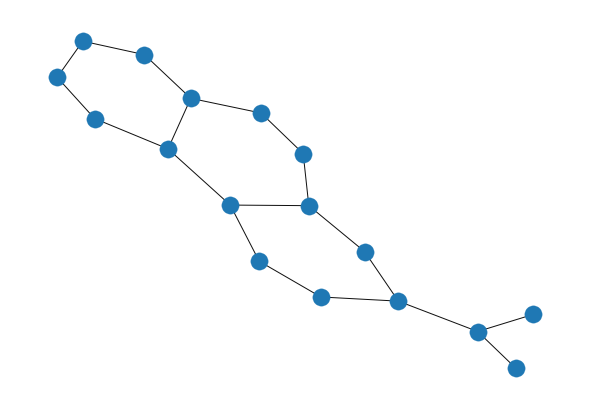

In [57]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[0])
nx.draw(G)

Process the data

In [58]:
# For MUTAG

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: Simple_Encoder(to_kx(x),F_list, line = False, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
#%timeit X = encode(dataset[0])


1 loop, best of 5: 759 ms per loop


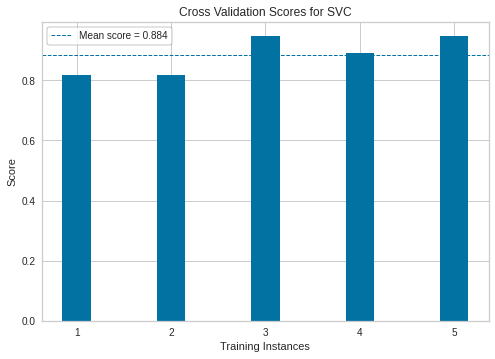

In [54]:
# Run classifier - MUTAG

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='f1_weighted', random_state=42)
visualizer.fit(X, y)        
visualizer.show()   


## Experiment: IMDB 

Load the data

In [59]:
dataset = TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: IMDB-BINARY(1000):
Number of graphs: 1000
Number of features: 0
Number of classes: 2

Data(edge_index=[2, 146], y=[1], num_nodes=20)


Inspect:

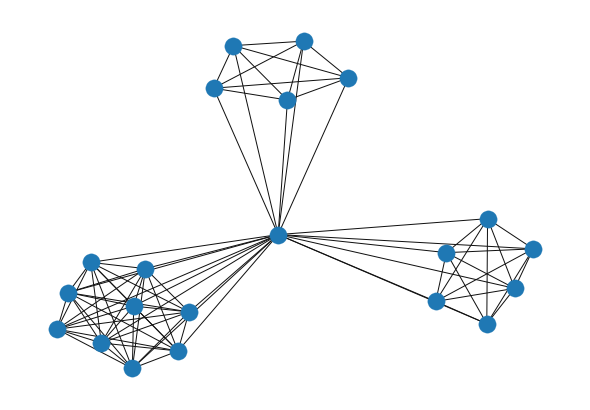

In [60]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[2])
nx.draw(G)



In [ ]:
# For IMDB-BIN

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: Simple_Encoder(to_kx(x),F_list, line = False, format ='numpy')
X = [encode(data) for data in tqdm(dataset)]
#%timeit X = encode(dataset[0])
#encode(dataset[6])

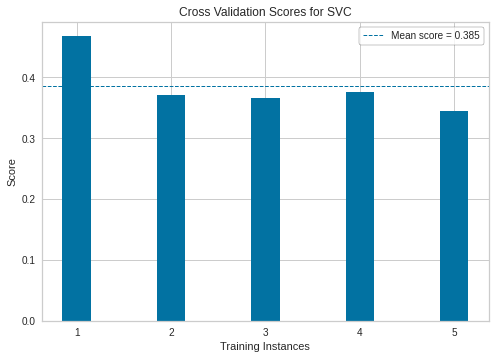

In [20]:
# Run classifier - IMDB-BIN

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='f1_weighted', random_state=42)
visualizer.fit(X, y)        
visualizer.show()   